# Qualitative error analysis

In [1]:
from __future__ import print_function
from __future__ import division
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pdb
from datetime import datetime
from plyer import notification
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import time
import copy
import random
import glob as gb
import cv2
import tifffile as tiff

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn



%matplotlib inline
%load_ext autoreload
%autoreload 2


#torch.use_deterministic_algorithms(True)    # Enforces reproducibility elsewhere as long as I seed

def seed_all(s):
    random.seed(s)
    torch.manual_seed(s)
    np.random.seed(s)
    
chosen_seed = 0
seed_all(chosen_seed)


import torch
torch.cuda.empty_cache()

# Confirm that the GPU is detected
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: NVIDIA GeForce RTX 3080 Laptop GPU, n_gpu: 1


## Choose 4 random validation samples

In [2]:
IMSIZE = 512
DATA_PATH = "data/"

# Read data
val_image_paths = sorted(gb.glob(os.path.join(DATA_PATH, 'val_images/*tiff')))
print(f"Number of validation images : {len(val_image_paths)}")
print(f"First validation image : {val_image_paths[0]}")

# Create a dictionary where keys are image shapes and values are number of images with that shape
val_image_shapes = {}
for ind, image_path in enumerate(val_image_paths):
    image = cv2.imread(image_path)
    val_image_shapes[image.shape] = val_image_shapes.get(image.shape, 0) + 1
print("Validation image shapes:")
print(val_image_shapes)


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from wrens_utils import CustomImageDataset

# Create transform
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMSIZE, IMSIZE)),
    # TODO: RE-ENABLE NORMALIZATION IF IT LEADS TO BETTER RESULTS
    #transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Create custom Dataset
val_dataset = CustomImageDataset(annotations_file=os.path.join(DATA_PATH, "val.csv"), img_dir=os.path.join(DATA_PATH, "val_images/"), transform=val_transforms, target_transform=None, imsize=IMSIZE)

# Create custom DataLoader to wrap the Dataset
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

# Grab 3 images and their labels
iterator = iter(val_dataloader)
images, labels = iterator.next()
images = images.to(device)

Number of validation images : 207
First validation image : data/val_images\0_A001-C-224_cns_patch_0_0_largeintestine.tiff
Validation image shapes:
{(4367, 4367, 3): 6, (3000, 3000, 3): 115, (2654, 2654, 3): 2, (2023, 2023, 3): 23, (2764, 2764, 3): 1, (2760, 2760, 3): 2, (2680, 2680, 3): 1, (3070, 3070, 3): 2, (2631, 2631, 3): 1, (2790, 2790, 3): 1, (2869, 2869, 3): 1, (2416, 2416, 3): 1, (2942, 2942, 3): 1, (160, 160, 3): 15, (1323, 1323, 3): 19, (2000, 2000, 3): 16}


## Load both models

In [3]:
# Best DeepLabV3
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
weights_deeplabv3 = DeepLabV3_ResNet101_Weights.DEFAULT
model_deeplabv3 = deeplabv3_resnet101(weights=weights_deeplabv3)
model_deeplabv3.cuda()
model_deeplabv3.load_state_dict(torch.load('trained_models/0_coarse_grid_search_less_data/modeldate2023-04-06,15_19_39.403064_bs4_lr2e-05_wd0_epochs39_imsize512_valloss0.9043.pth'))


# Best UNet
enc_name = "resnet101"
enc_weights = "imagenet"
model_unet = smp.Unet(encoder_name=enc_name, encoder_depth=5,
                    encoder_weights=enc_weights, decoder_use_batchnorm=True,
                    decoder_channels=[256, 128, 64, 32, 16],
                    in_channels=3, classes=1)
model_unet = model_unet.cuda()
model_unet.load_state_dict(torch.load('trained_models/6_good_unet/modeldate2023-04-18,04_00_23.290289_bs4_lr1e-05_wd0_epochs99_imsize512_valloss0.1291.pth'))

<All keys matched successfully>

## Create figure(s) comparing the models' outputs on these validation samples

In [4]:
# Get outputs

# DeepLabV3
images_for_models = images.movedim(-1, 1)  # Change from [N, W, H, C] to [N, C, W, H] (or maybe W and H are reversed)
logits_deeplabv3 = model_deeplabv3(images_for_models)["out"]
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights_deeplabv3.meta["categories"])}
logits_deeplabv3 = logits_deeplabv3[:, class_to_idx["sofa"], :, :].cpu()

# UNet
logits_unet = model_unet(images_for_models).squeeze().cpu()

# Move other stuff to CPU
images = images.cpu()
labels = labels.cpu()

In [5]:
print(labels.size())
print(logits_deeplabv3.size())
print(logits_unet.size())
assert(labels.size() == logits_deeplabv3.size() == logits_unet.size())

torch.Size([4, 512, 512])
torch.Size([4, 512, 512])
torch.Size([4, 512, 512])


In [6]:
logits_deeplabv3 = logits_deeplabv3.detach().numpy()
logits_unet = logits_unet.detach().numpy()

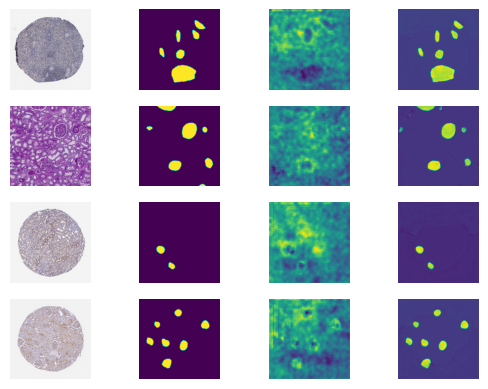

In [7]:
# Plot
plt.figure()

counter = 1
for cc in range(4):
    plt.subplot(4, 4, counter)
    plt.imshow(images[cc])
    plt.axis("off")
    counter += 1

    plt.subplot(4, 4, counter)
    plt.imshow(labels[cc])
    plt.axis("off")
    counter += 1
    
    plt.subplot(4, 4, counter)
    plt.imshow(logits_deeplabv3[cc])
    plt.axis("off")
    counter += 1

    plt.subplot(4, 4, counter)
    plt.imshow(logits_unet[cc])
    plt.axis("off")
    counter += 1

plt.show()